In [ ]:
"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# Installing required python libraries

In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars[numpy,pandas,pyarrow] --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
!pip install plotly
!pip install librosa
!pip install -U imbalanced-learn==0.12.4

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg/polars-0.20.16-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 66.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 24.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import duckdb as dd
import polars as pl
import pyarrow
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import plotly.express as px
import librosa
import pickle
from joblib import dump, load
from pathlib import Path
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

E0000 00:00:1743929099.564947      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230
/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1743929161.958565      10 service.cc:148] XLA service 0x572ffda604e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743929161.958612      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1743929161.958617      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1743929161.958621      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1743929161.958624      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1743929161.958628      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1743929161.958631      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1743929161.958634      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1743929161.958637      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
# Path to the directory containing your audio dataset
dataset_dir = '/kaggle/input/birdclef-2025/train_audio'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label
            
# label_mapping

# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])

label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])

print("dataset size: ",annotated_data.shape)

dataset size:  (28564, 3)


In [5]:
annotated_data.head(5)

audio_file_path    label  encoded_label
0  /kaggle/input/birdclef-2025/train_audio/greani...  greani1            110
1  /kaggle/input/birdclef-2025/train_audio/greani...  greani1            110
2  /kaggle/input/birdclef-2025/train_audio/greani...  greani1            110
3  /kaggle/input/birdclef-2025/train_audio/greani...  greani1            110
4  /kaggle/input/birdclef-2025/train_audio/greani...  greani1            110

In [5]:
pl.Config(tbl_rows=200)
dd.sql("select * from \
    (select label, files, row_number()over(order by files desc) as rn from \
        (select label, count(distinct(audio_file_path)) as files from annotated_data group by label \
        )t1 \
    )t2 where rn <= 100").pl()

shape: (100, 3)
┌─────────┬───────┬─────┐
│ label   ┆ files ┆ rn  │
│ ---     ┆ ---   ┆ --- │
│ str     ┆ i64   ┆ i64 │
╞═════════╪═══════╪═════╡
│ grekis  ┆ 990   ┆ 1   │
│ compau  ┆ 808   ┆ 2   │
│ trokin  ┆ 787   ┆ 3   │
│ roahaw  ┆ 709   ┆ 4   │
│ banana  ┆ 610   ┆ 5   │
│ whtdov  ┆ 572   ┆ 6   │
│ socfly1 ┆ 543   ┆ 7   │
│ yeofly1 ┆ 525   ┆ 8   │
│ bobfly1 ┆ 514   ┆ 9   │
│ wbwwre1 ┆ 499   ┆ 10  │
│ soulap1 ┆ 487   ┆ 11  │
│ sobtyr1 ┆ 478   ┆ 12  │
│ trsowl  ┆ 470   ┆ 13  │
│ laufal1 ┆ 467   ┆ 14  │
│ strcuc1 ┆ 431   ┆ 15  │
│ bbwduc  ┆ 424   ┆ 16  │
│ saffin  ┆ 419   ┆ 17  │
│ amekes  ┆ 409   ┆ 18  │
│ tropar  ┆ 397   ┆ 19  │
│ compot1 ┆ 383   ┆ 20  │
│ blbgra1 ┆ 380   ┆ 21  │
│ bubwre1 ┆ 379   ┆ 22  │
│ strfly1 ┆ 377   ┆ 23  │
│ gycwor1 ┆ 365   ┆ 24  │
│ greegr  ┆ 340   ┆ 25  │
│ linwoo1 ┆ 330   ┆ 26  │
│ pirfly1 ┆ 324   ┆ 27  │
│ littin1 ┆ 323   ┆ 28  │
│ bkmtou1 ┆ 311   ┆ 29  │
│ yercac1 ┆ 302   ┆ 30  │
│ butsal1 ┆ 298   ┆ 31  │
│ smbani  ┆ 287   ┆ 32  │
│ bugtan  ┆ 280   ┆ 33  │
│ chbant1 ┆ 270   ┆ 34  │
│ yebela1 ┆ 267   ┆ 35  │
│ rutjac1 ┆ 261   ┆ 36  │
│ cotfly1 ┆ 260   ┆ 37  │
│ whbman1 ┆ 246   ┆ 38  │
│ yehcar1 ┆ 238   ┆ 39  │
│ solsan  ┆ 237   ┆ 40  │
│ rumfly1 ┆ 236   ┆ 41  │
│ yecspi2 ┆ 235   ┆ 42  │
│ blhpar1 ┆ 230   ┆ 43  │
│ creoro1 ┆ 229   ┆ 44  │
│ paltan1 ┆ 224   ┆ 45  │
│ rinkin1 ┆ 222   ┆ 46  │
│ orcpar  ┆ 218   ┆ 47  │
│ stbwoo2 ┆ 210   ┆ 48  │
│ speowl1 ┆ 201   ┆ 49  │
│ yebfly1 ┆ 188   ┆ 50  │
│ plbwoo1 ┆ 186   ┆ 51  │
│ yebsee1 ┆ 185   ┆ 52  │
│ bkcdon  ┆ 176   ┆ 53  │
│ y00678  ┆ 169   ┆ 54  │
│ strher  ┆ 169   ┆ 55  │
│ babwar  ┆ 167   ┆ 56  │
│ strowl1 ┆ 164   ┆ 57  │
│ gybmar  ┆ 164   ┆ 58  │
│ cocwoo1 ┆ 162   ┆ 59  │
│ secfly1 ┆ 158   ┆ 60  │
│ thbeup1 ┆ 153   ┆ 61  │
│ pavpig2 ┆ 151   ┆ 62  │
│ baymac  ┆ 149   ┆ 63  │
│ rtlhum  ┆ 148   ┆ 64  │
│ purgal2 ┆ 147   ┆ 65  │
│ colcha1 ┆ 145   ┆ 66  │
│ crcwoo1 ┆ 144   ┆ 67  │
│ ywcpar  ┆ 142   ┆ 68  │
│ chfmac1 ┆ 139   ┆ 69  │
│ rugdov  ┆ 138   ┆ 70  │
│ gohman1 ┆ 134   ┆ 71  │
│ watjac1 ┆ 133   ┆ 72  │
│ grnkin  ┆ 132   ┆ 73  │
│ greani1 ┆ 127   ┆ 74  │
│ whfant1 ┆ 126   ┆ 75  │
│ cattyr  ┆ 114   ┆ 76  │
│ srwswa1 ┆ 112   ┆ 77  │
│ blbwre1 ┆ 110   ┆ 78  │
│ greibi1 ┆ 109   ┆ 79  │
│ mastit1 ┆ 109   ┆ 80  │
│ snoegr  ┆ 108   ┆ 81  │
│ leagre  ┆ 108   ┆ 82  │
│ blcjay1 ┆ 108   ┆ 83  │
│ 41663   ┆ 108   ┆ 84  │
│ grbhaw1 ┆ 107   ┆ 85  │
│ blcant4 ┆ 105   ┆ 86  │
│ eardov1 ┆ 105   ┆ 87  │
│ whbant1 ┆ 104   ┆ 88  │
│ rufmot1 ┆ 97    ┆ 89  │
│ yectyr1 ┆ 97    ┆ 90  │
│ thlsch3 ┆ 97    ┆ 91  │
│ cargra1 ┆ 94    ┆ 92  │
│ bicwre1 ┆ 93    ┆ 93  │
│ anhing  ┆ 91    ┆ 94  │
│ recwoo1 ┆ 90    ┆ 95  │
│ shtfly1 ┆ 90    ┆ 96  │
│ neocor  ┆ 90    ┆ 97  │
│ amakin1 ┆ 89    ┆ 98  │
│ ragmac1 ┆ 89    ┆ 99  │
│ grasal4 ┆ 85    ┆ 100 │
└─────────┴───────┴─────┘

In [6]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 50  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot

def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

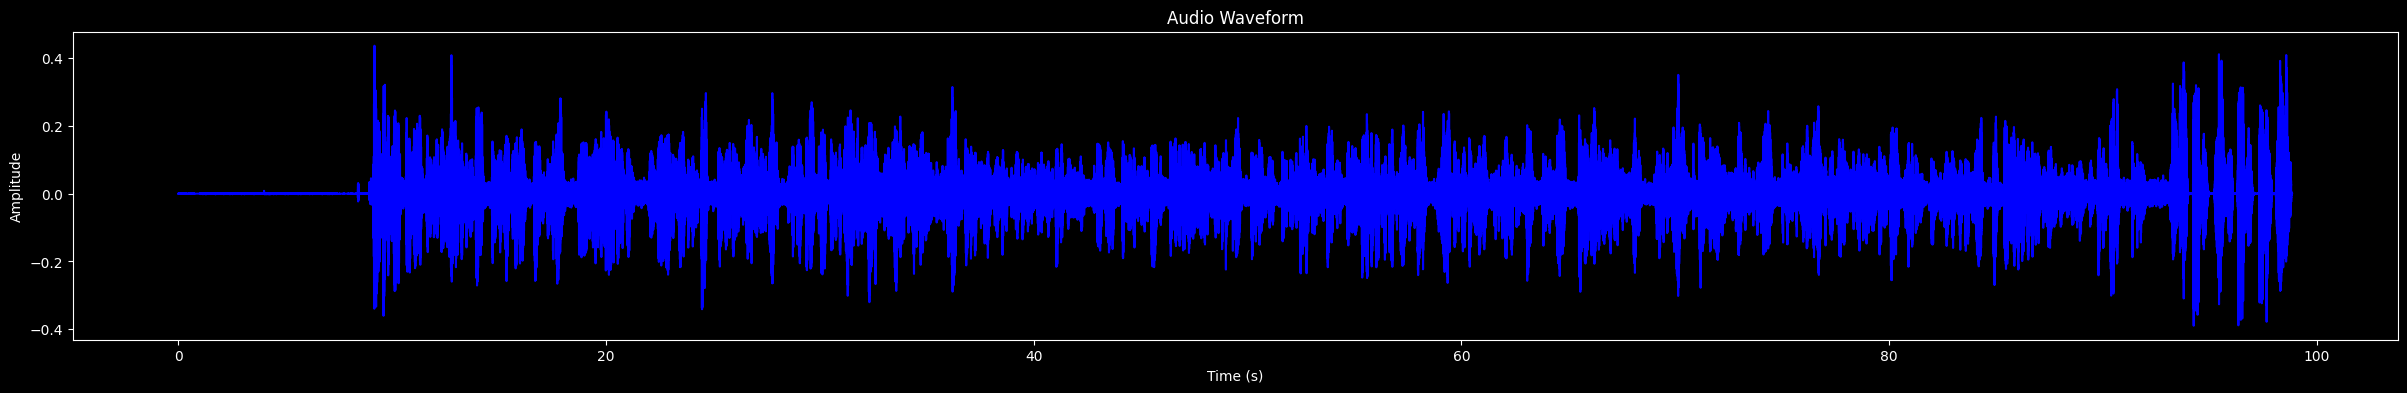

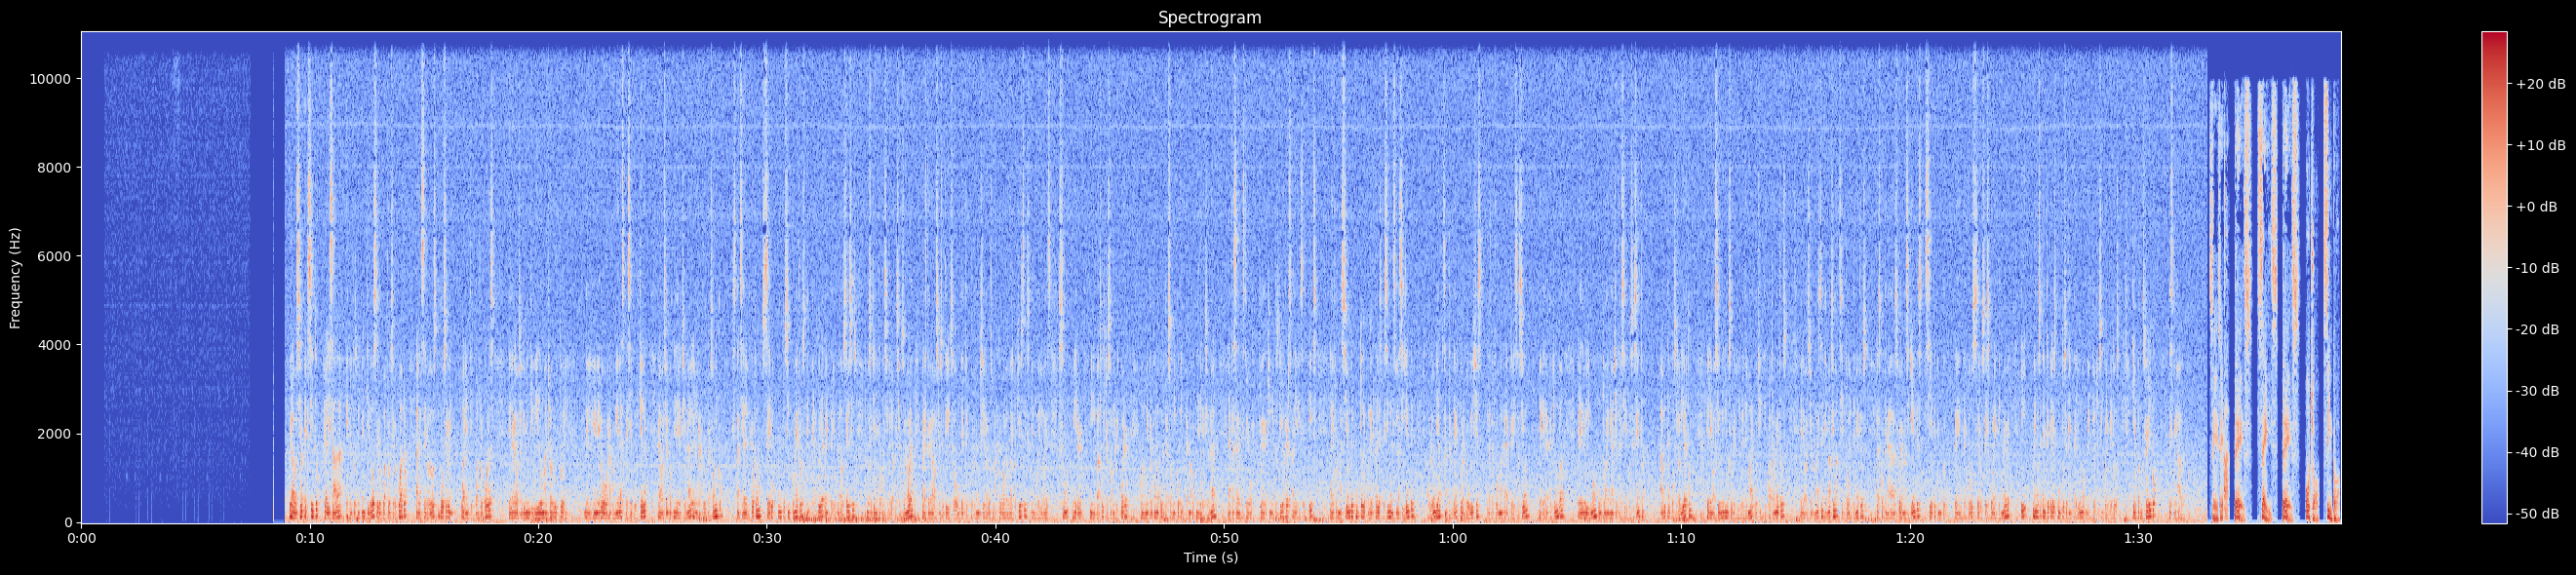

In [17]:
audio_analysis('/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg')
y, sr = librosa.load('/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg')
Audio(y, rate=sr)

# Get the metadata

In [6]:
meta_data_schema = {
    "primary_label": pl.String,
    "secondary_labels": pl.String,
    "type": pl.String,
    "filename": pl.String,
    "collection": pl.String,
    "rating": pl.Float64,
    "url": pl.String,
    "latitude": pl.Float64,
    "longitude": pl.Float64,
    "scientific_name": pl.String,
    "common_name": pl.String,
    "author": pl.String,
    "license": pl.String
}

meta_data = pl.read_csv('/kaggle/input/birdclef-2025/train.csv',has_header=True, schema=meta_data_schema
                        , low_memory=True, null_values=["NA", "", "null","None"])

meta_data = meta_data.with_columns(
    pl.concat_str([pl.lit('/kaggle/input/birdclef-2025/train_audio/'),pl.col('filename')],separator='')\
                                   .alias('filename'))

#meta_data = meta_data.select(pl.exclude('filename'))

#meta_data = meta_data.rename({"full_file_path": "filename"})

meta_data.head(5)

shape: (5, 13)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ primary_la ┆ secondary_ ┆ type ┆ filename   ┆ … ┆ scientific ┆ common_na ┆ author    ┆ license   │
│ bel        ┆ labels     ┆ ---  ┆ ---        ┆   ┆ _name      ┆ me        ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ str  ┆ str        ┆   ┆ ---        ┆ ---       ┆ str       ┆ str       │
│ str        ┆ str        ┆      ┆            ┆   ┆ str        ┆ str       ┆           ┆           │
╞════════════╪════════════╪══════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1139490    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Ragoniella ┆ Ragoniell ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ pulchella  ┆ a         ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆            ┆ pulchella ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1139490    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Ragoniella ┆ Ragoniell ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ pulchella  ┆ a         ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆            ┆ pulchella ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴──────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

# Remove the recordings that have human voice

In [7]:
author_map = {
    'Alexandra Butrago-Cardona': 'Alexandra Buitrago-Cardona',
    'Ana María Ospina-Larrea | Daniela Murillo': 'Ana María Ospina-Larrea',
    'Diego A Gómez-Morales': 'Diego A. Gomez-Morales',
    'Eliana Barona- Cortés': 'Eliana Barona-Cortés',
    'Eliana Barona-Cortés | Daniela García-Cobos': 'Eliana Barona-Cortés',
    'Paula Caycedo-Rosales | Juan-Pablo López': 'Paula Caycedo-Rosales',
    'Fabio A. Sarria-S': 'Fabio A. Sarria-S'
}

sounds_to_exclude = meta_data.filter(
    pl.col("author").is_in (list(author_map.keys()))
)

In [16]:
dd.sql("select * from sounds_to_exclude where filename = '/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg'").pl()

shape: (1, 13)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ primary_la ┆ secondary_ ┆ type ┆ filename   ┆ … ┆ scientific ┆ common_na ┆ author    ┆ license   │
│ bel        ┆ labels     ┆ ---  ┆ ---        ┆   ┆ _name      ┆ me        ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ str  ┆ str        ┆   ┆ ---        ┆ ---       ┆ str       ┆ str       │
│ str        ┆ str        ┆      ┆            ┆   ┆ str        ┆ str       ┆           ┆           │
╞════════════╪════════════╪══════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1139490    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Ragoniella ┆ Ragoniell ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ pulchella  ┆ a         ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆            ┆ pulchella ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴──────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [17]:
dd.sql('select collection, count(distinct(filename)) as file_count from sounds_to_exclude group by collection order by 2 desc').pl()

shape: (1, 2)
┌────────────┬────────────┐
│ collection ┆ file_count │
│ ---        ┆ ---        │
│ str        ┆ i64        │
╞════════════╪════════════╡
│ CSA        ┆ 41         │
└────────────┴────────────┘

In [18]:
pl.Config(tbl_rows=200)
dd.sql("select * from (select author, file_count, row_number()over(order by file_count desc) rn \
from (select author, count(distinct(filename)) as file_count from sounds_to_exclude \
group by author)t1)t2 where rn <= 50 order by file_count desc"\
      ).pl()

shape: (7, 3)
┌───────────────────────────────────┬────────────┬─────┐
│ author                            ┆ file_count ┆ rn  │
│ ---                               ┆ ---        ┆ --- │
│ str                               ┆ i64        ┆ i64 │
╞═══════════════════════════════════╪════════════╪═════╡
│ Fabio A. Sarria-S                 ┆ 26         ┆ 1   │
│ Diego A Gómez-Morales             ┆ 5          ┆ 2   │
│ Eliana Barona- Cortés             ┆ 4          ┆ 3   │
│ Alexandra Butrago-Cardona         ┆ 2          ┆ 4   │
│ Ana María Ospina-Larrea | Daniel… ┆ 2          ┆ 5   │
│ Eliana Barona-Cortés | Daniela G… ┆ 1          ┆ 6   │
│ Paula Caycedo-Rosales | Juan-Pab… ┆ 1          ┆ 7   │
└───────────────────────────────────┴────────────┴─────┘

In [19]:
sounds_to_exclude.head(5)

shape: (5, 13)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ primary_la ┆ secondary_ ┆ type ┆ filename   ┆ … ┆ scientific ┆ common_na ┆ author    ┆ license   │
│ bel        ┆ labels     ┆ ---  ┆ ---        ┆   ┆ _name      ┆ me        ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ str  ┆ str        ┆   ┆ ---        ┆ ---       ┆ str       ┆ str       │
│ str        ┆ str        ┆      ┆            ┆   ┆ str        ┆ str       ┆           ┆           │
╞════════════╪════════════╪══════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1139490    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Ragoniella ┆ Ragoniell ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ pulchella  ┆ a         ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆            ┆ pulchella ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1139490    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Ragoniella ┆ Ragoniell ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ pulchella  ┆ a         ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆            ┆ pulchella ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
│ 1192948    ┆ ['']       ┆ [''] ┆ /kaggle/in ┆ … ┆ Oxyprora   ┆ Oxyprora  ┆ Fabio A.  ┆ cc-by-nc- │
│            ┆            ┆      ┆ put/birdcl ┆   ┆ surinamens ┆ surinamen ┆ Sarria-S  ┆ sa 4.0    │
│            ┆            ┆      ┆ ef-2025/tr ┆   ┆ is         ┆ sis       ┆           ┆           │
│            ┆            ┆      ┆ ai…        ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴──────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [9]:
final_train_df = dd.sql("select t1.* \
    from annotated_data t1 \
    left join sounds_to_exclude t2 \
    on t1.audio_file_path = t2.filename \
    where t2.author is null").pl()

# Arrive at the final training dataset

In [10]:
final_train_df.shape

(28523, 3)

In [24]:
final_train_df.tail(5)

shape: (5, 3)
┌───────────────────────────────────┬─────────┬───────────────┐
│ audio_file_path                   ┆ label   ┆ encoded_label │
│ ---                               ┆ ---     ┆ ---           │
│ str                               ┆ str     ┆ i64           │
╞═══════════════════════════════════╪═════════╪═══════════════╡
│ /kaggle/input/birdclef-2025/trai… ┆ wbwwre1 ┆ 185           │
│ /kaggle/input/birdclef-2025/trai… ┆ wbwwre1 ┆ 185           │
│ /kaggle/input/birdclef-2025/trai… ┆ wbwwre1 ┆ 185           │
│ /kaggle/input/birdclef-2025/trai… ┆ wbwwre1 ┆ 185           │
│ /kaggle/input/birdclef-2025/trai… ┆ wbwwre1 ┆ 185           │
└───────────────────────────────────┴─────────┴───────────────┘

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test_val = train_test_split(final_train_df, test_size=0.4, random_state=42)
x_test, x_valid = train_test_split(x_test_val, test_size=0.2, random_state=42)

print("Training data shape : {0}".format(x_train.shape))
print("Test data shape : {0}".format(x_test.shape))
print("Validation data shape : {0}".format(x_valid.shape))

Training data shape : (17113, 3)
Test data shape : (9128, 3)
Validation data shape : (2282, 3)


In [12]:
def load_and_process_audio(file_path, label):
    # Decode the file path from bytes to string
    file_path = file_path.numpy().decode('utf-8')
    
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=32000)
    samples_per_segment = sample_rate * 5
    total_samples = min(len(audio), 7680000)  # Limit to 7680000 samples

    segments = []
    for j in range(0, total_samples + 160000, samples_per_segment):
        if j + samples_per_segment <= total_samples:
            segment = audio[j:j + samples_per_segment]
            mfccs = librosa.feature.mfcc(y=segment, sr=32000, n_mfcc=40)
            flattened_features = np.mean(mfccs.T, axis=0)
            segments.append((flattened_features, label))

    # Check if segments are created
    if not segments:
        #print(f"No segments created for file: {file_path}")
        return tf.convert_to_tensor([], dtype=tf.float32), tf.convert_to_tensor([], dtype=tf.int32)
    
    # Convert segments to tensors
    features, labels = zip(*segments)  # Unzip the list of tuples
    features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)  # Adjust dtype as needed

    return features_tensor, labels_tensor

# Create a TensorFlow Dataset
def create_dataset(final_train_df):
    # Create a dataset from the Polars DataFrame
    file_paths = final_train_df['audio_file_path'].to_numpy()  # Access the 'filename' column
    labels = final_train_df['encoded_label'].to_numpy()  # Access the 'label' column

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # Map the load_and_process_audio function to each element in the dataset
    #dataset = dataset.flat_map(lambda file_path, label: tf.data.Dataset.from_tensors(load_and_process_audio(file_path, label)).unbatch())

    # Use tf.py_function to wrap the load_and_process_audio function
    dataset = dataset.map(lambda file_path, label: tf.py_function(
        func=load_and_process_audio,
        inp=[file_path, label],
        Tout=[tf.float32, tf.int32]  # Specify output types
    ))
    
    return dataset

In [13]:
#with tpu_strategy.scope():
train_dataset = create_dataset(x_train)
test_dataset = create_dataset(x_test)
valid_dataset = create_dataset(x_valid)

In [48]:
features = []
labels = []

#with tpu_strategy.scope():
for batch in dataset:
    # Convert the batch tensors to numpy arrays
    print(f"Batch shape: {batch[0].shape}, {batch[1].shape}")
    
    features_batch = batch[0].numpy()  # Get the features tensor
    labels_batch = batch[1].numpy()    # Get the labels tensor
    
    features.append(features_batch)
    labels.append(labels_batch)

# Convert features and labels to numpy arrays if needed
features = np.concatenate(features, axis=0)  # Concatenate all batches
labels = np.concatenate(labels, axis=0)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Batch shape: (4, 40), (4,)
Batch shape: (1, 40), (1,)
Batch shape: (1, 40), (1,)
Batch shape: (1, 40), (1,)
Batch shape: (10, 40), (10,)
Batch shape: (6, 40), (6,)
Batch shape: (2, 40), (2,)
Batch shape: (10, 40), (10,)
Batch shape: (18, 40), (18,)
Batch shape: (7, 40), (7,)
Batch shape: (12, 40), (12,)
Batch shape: (2, 40), (2,)
Batch shape: (18, 40), (18,)
No segments created for file: /kaggle/input/birdclef-2025/train_audio/greani1/XC137815.ogg
Batch shape: (0,), (0,)
Batch shape: (19, 40), (19,)
Batch shape: (4, 40), (4,)
Batch shape: (9, 40), (9,)
Batch shape: (12, 40), (12,)
Batch shape: (2, 40), (2,)
Batch shape: (11, 40), (11,)
No segments created for file: /kaggle/input/birdclef-2025/train_audio/greani1/XC646808.ogg
Batch shape: (0,), (0,)
Batch shape: (17, 40), (17,)
Batch shape: (18, 40), (18,)
Batch shape: (7, 40), (7,)
Batch shape: (6, 40), (6,)
Batch shape: (6, 40), (6,)
Batch shape: (25, 40), (25,)
Batch shape: (10, 40), (10,)
Batch shape: (24, 40), (24,)
Batch shape: (5

KeyboardInterrupt: 

In [25]:
#from tqdm import tqdm

labels = []
features = []

# Loop through each audio file in the dataset directory
for i in range(final_train_df.shape[0]):
    file_path = final_train_df.item(i,0)
    audio, sample_rate = librosa.load(file_path, sr=32000)
    samples_per_segment = sample_rate * 5
    if len(audio) > 7680000:
        total_samples = 7680000
    else:
        total_samples = len(audio)

    for j in range(0, total_samples+160000, samples_per_segment):
        if j + samples_per_segment <= total_samples:
            segment = audio[j:j + samples_per_segment]
            mfccs = librosa.feature.mfcc(y=segment, sr=32000, n_mfcc=40)
            flattened_features = (np.mean(mfccs.T, axis=0))
            features.append(flattened_features)
            labels.append(final_train_df.item(i,2))

In [26]:
extracted_training_features_five_sec = np.array(features)
labels_five_sec = np.array(labels)

In [27]:
with open("extracted_train_feat_five_sec_v5_2025", "wb") as file:   #Pickling
    pickle.dump(extracted_training_features_five_sec, file)
    
with open("labels_five_sec_v5_2025", "wb") as file:   #Pickling
    pickle.dump(labels_five_sec, file)

In [14]:
feature_file_path = '/kaggle/input/birdclef-2025-features-labels-v1/extracted_train_feat_five_sec_v5_2025'
label_file_path = '/kaggle/input/birdclef-2025-features-labels-v1/labels_five_sec_v5_2025'

with open(feature_file_path, "rb") as file:
    pickled_extracted_features_five_sec = pickle.load(file)
    
with open(label_file_path, "rb") as file:
    labels_five_sec = pickle.load(file)

In [15]:
x_five_sec = np.vstack(pickled_extracted_features_five_sec)
y_five_sec = labels_five_sec

print(x_five_sec.shape)
print(y_five_sec.shape)

(180142, 40)
(180142,)


In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
"""param_grid = dict(gamma=gamma_range, C=C_range, kernel=['rbf'])
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_five_sec_scaled = scaler.fit_transform(x_five_sec)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(x_five_sec_scaled, y_five_sec)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)"""

'param_grid = dict(gamma=gamma_range, C=C_range, kernel=[\'rbf\'])\ncv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n\nscaler = StandardScaler()\nx_five_sec_scaled = scaler.fit_transform(x_five_sec)\n\ngrid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)\ngrid.fit(x_five_sec_scaled, y_five_sec)\n\nprint(\n    "The best parameters are %s with a score of %0.2f"\n    % (grid.best_params_, grid.best_score_)\n)'

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", C=C_range[5], gamma=gamma_range[4], probability=True, class_weight="balanced"))
])

sample_labels = [i for i in range(0, 182, 1)]
y_onehot_tests, y_scores = dict(), dict()

for fold, (train, test) in enumerate(skf.split(x_five_sec, y_five_sec)):
    print("fold = {0}".format(fold))
    x_train = np.ascontiguousarray(x_five_sec[train])
    y_train = np.ascontiguousarray(y_five_sec[train])
    x_test = np.ascontiguousarray(x_five_sec[test])
    y_test = np.ascontiguousarray(y_five_sec[test])
    print("train feature shape & label shape = {0} & {1}".format(x_train.shape, y_train.shape))
    print("test feature shape & label shape = {0} & {1}".format(x_test.shape, y_test.shape))
    rbf_kernel_svm_model = rbf_kernel_svm_clf.fit(x_train, y_train)
    y_predict = rbf_kernel_svm_model.predict_proba(x_test)
    print("predictions shape = {0}".format(y_predict.shape))
    ras_ovr = roc_auc_score(y_test, y_predict, multi_class='ovr', average='macro', labels=sample_labels)
    ras_ovo = roc_auc_score(y_test, y_predict, multi_class='ovo', average='macro', labels=sample_labels)
    print(f"Macro-averaged One-vs-Rest ROC AUC score: ", round(ras_ovr,2))
    print(f"Macro-averaged One-vs-One ROC AUC score: ", round(ras_ovo,2))
    y_scores[fold] = y_predict
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_tests[fold] = y_onehot_test

/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold = 0
train feature shape & label shape = (144113, 40) & (144113,)
test feature shape & label shape = (36029, 40) & (36029,)
